# **Acute Lymphoblastic Leukemia (ALL) Detection**


![](https://eclinpath.com/wp-content/gallery/glandular-tissue/mammary469.jpg)

*prageethm*

In [42]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torch.nn.functional as F
import torchvision.transforms as transforms
import random


from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import random_split, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

In [2]:
root_dir = '/kaggle/input/blood-cell-cancer-all-4class'

def show_files_per_class(base_path, num_files=10):
    for folder in sorted(os.listdir(base_path)):
        folder_path = os.path.join(base_path, folder)
        if os.path.isdir(folder_path):
            print(f'\n{folder}/')
            files = os.listdir(folder_path)
            for f in files[:num_files]:
                print(f'   |- {f}')
show_files_per_class(root_dir)


Blood cell Cancer [ALL]/
   |- [Malignant] early Pre-B
   |- [Malignant] Pro-B
   |- [Malignant] Pre-B
   |- Benign


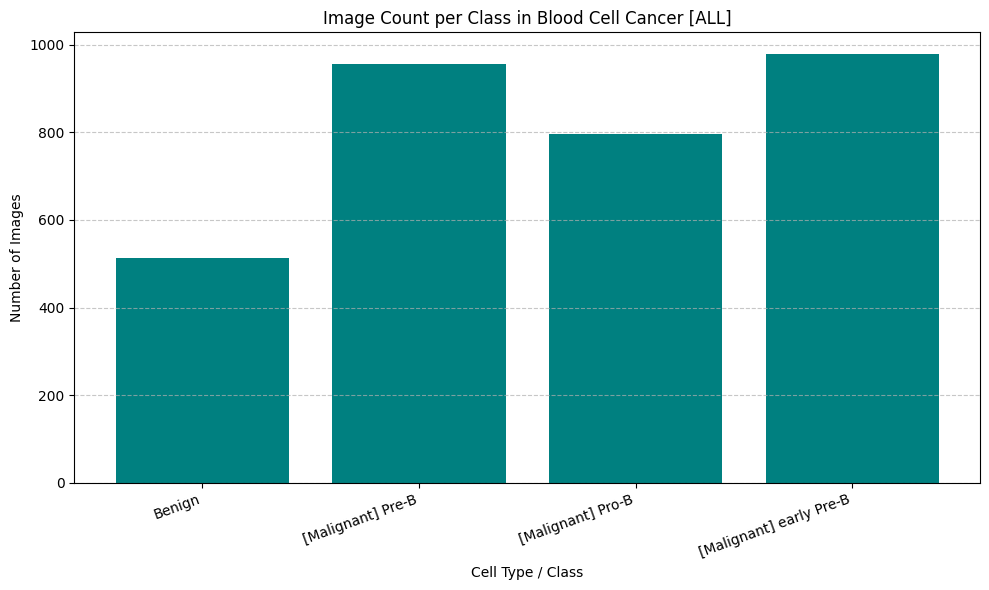

In [3]:
dataset_dir = '/kaggle/input/blood-cell-cancer-all-4class/Blood cell Cancer [ALL]'

class_counts = {}
for class_name in sorted(os.listdir(dataset_dir)):
    class_path = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_path):
        num_images = len([f for f in os.listdir(class_path) if f.endswith(('.jpg'))])
        class_counts[class_name] = num_images

plt.figure(figsize = (10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='teal')
plt.xticks(rotation = 20, ha = 'right')
plt.title('Image Count per Class in Blood Cell Cancer [ALL]')
plt.xlabel('Cell Type / Class')
plt.ylabel('Number of Images')
plt.grid(axis = 'y', linestyle = '--', alpha=0.7)
plt.tight_layout()
plt.show()

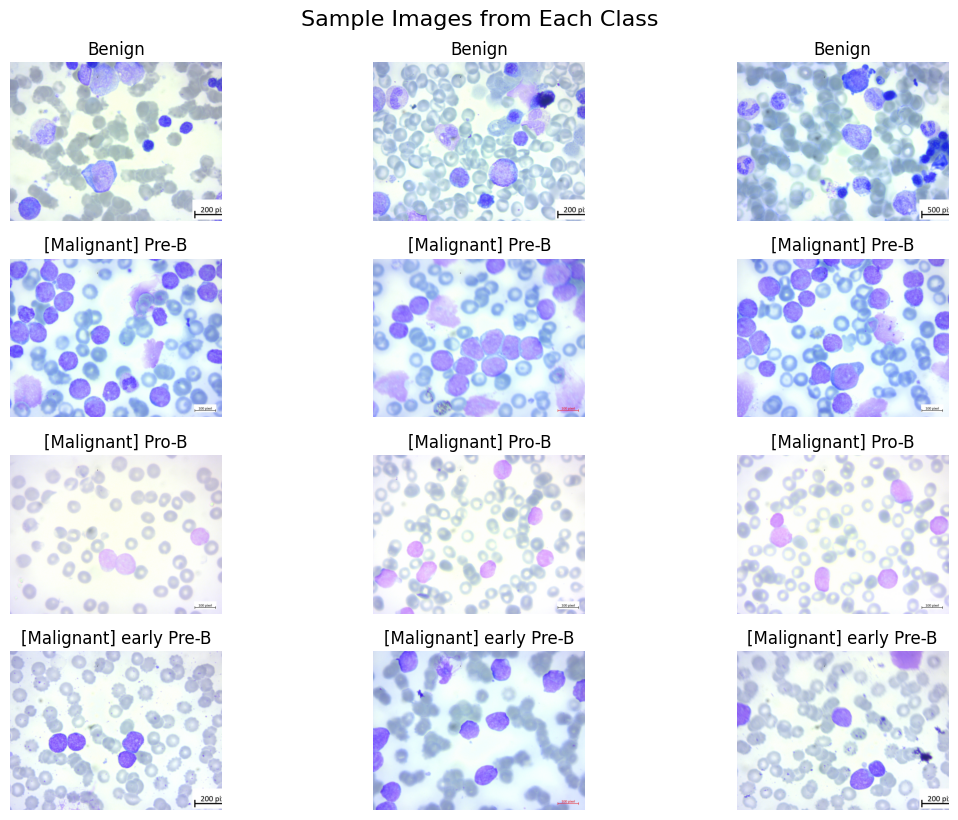

In [4]:
num_samples = 3

plt.figure(figsize = (12, 8))
class_folders = sorted(os.listdir(dataset_dir))
img_idx = 1

for class_name in class_folders:
    class_path = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_path):
        img_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg'))][:num_samples]
        
        for img_file in img_files:
            img_path = os.path.join(class_path, img_file)
            img = mpimg.imread(img_path)
            
            plt.subplot(len(class_folders), num_samples, img_idx)
            plt.imshow(img)
            plt.axis('off')
            plt.title(class_name) 
            img_idx += 1

plt.tight_layout()
plt.suptitle('Sample Images from Each Class', fontsize = 16, y = 1.02)
plt.show()

# **PyTorch model**

In [5]:
dataset_dir = '/kaggle/input/blood-cell-cancer-all-4class/Blood cell Cancer [ALL]'

class_names = sorted(os.listdir(dataset_dir))
label_map = {name: idx for idx, name in enumerate(class_names)}
print("Label Map:", label_map)

Label Map: {'Benign': 0, '[Malignant] Pre-B': 1, '[Malignant] Pro-B': 2, '[Malignant] early Pre-B': 3}


In [6]:
class BloodCellDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label_name in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, label_name)
            if os.path.isdir(class_dir):
                for fname in os.listdir(class_dir):
                    if fname.endswith(('.jpg')):
                        self.image_paths.append(os.path.join(class_dir, fname))
                        self.labels.append(label_map[label_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                         std = [0.229, 0.224, 0.225])
])

In [8]:
full_dataset = BloodCellDataset(root_dir=dataset_dir, transform=transform)
print(f'Total images: {len(full_dataset)}')
image, label = full_dataset[0]
print(f'Image shape: {image.shape}, Label: {label} ({class_names[label]})')

Total images: 3242
Image shape: torch.Size([3, 224, 224]), Label: 3 ([Malignant] early Pre-B)


In [14]:
torch.manual_seed(42)
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

In [15]:
batch_size = 32 

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader   = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
test_loader  = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [16]:
images, labels = next(iter(train_loader))
print(f'Batch image tensor shape: {images.shape}')
print(f'Batch labels: {labels[:8]}')

Batch image tensor shape: torch.Size([32, 3, 224, 224])
Batch labels: tensor([1, 2, 2, 3, 2, 0, 3, 3])


In [18]:
num_classes = len(label_map)
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(model.fc.in_features, num_classes)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 175MB/s]


In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr = 0.001)

In [23]:
num_epochs = 50
patience = 3 
best_val_loss = float('inf')
early_stop_counter = 0

train_losses = []
val_losses = []

for epoch in range(num_epochs):

    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)


    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}% "
          f"| Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")


    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), 'best_model.pth') 
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"\n Early stopping triggered at epoch {epoch+1}")
            break

Epoch [1/50] Train Loss: 0.6240 | Train Acc: 80.96% | Val Loss: 0.2638 | Val Acc: 96.30%
Epoch [2/50] Train Loss: 0.2269 | Train Acc: 95.86% | Val Loss: 0.1577 | Val Acc: 96.50%
Epoch [3/50] Train Loss: 0.1630 | Train Acc: 96.83% | Val Loss: 0.1087 | Val Acc: 98.15%
Epoch [4/50] Train Loss: 0.1227 | Train Acc: 97.71% | Val Loss: 0.0867 | Val Acc: 98.35%
Epoch [5/50] Train Loss: 0.0982 | Train Acc: 98.10% | Val Loss: 0.0778 | Val Acc: 98.15%
Epoch [6/50] Train Loss: 0.0850 | Train Acc: 98.50% | Val Loss: 0.0717 | Val Acc: 98.77%
Epoch [7/50] Train Loss: 0.0802 | Train Acc: 98.33% | Val Loss: 0.0653 | Val Acc: 97.94%
Epoch [8/50] Train Loss: 0.0684 | Train Acc: 98.50% | Val Loss: 0.0674 | Val Acc: 97.94%
Epoch [9/50] Train Loss: 0.0614 | Train Acc: 98.50% | Val Loss: 0.0549 | Val Acc: 98.35%
Epoch [10/50] Train Loss: 0.0494 | Train Acc: 99.07% | Val Loss: 0.0542 | Val Acc: 98.56%
Epoch [11/50] Train Loss: 0.0514 | Train Acc: 99.07% | Val Loss: 0.0499 | Val Acc: 98.56%
Epoch [12/50] Train

In [27]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [30]:
print("Classification Report: \n")
print(classification_report(all_labels, all_preds, target_names = class_names))

Classification Report: 

                         precision    recall  f1-score   support

                 Benign       0.97      0.95      0.96        81
      [Malignant] Pre-B       1.00      0.99      1.00       138
      [Malignant] Pro-B       0.99      1.00      1.00       128
[Malignant] early Pre-B       0.98      0.99      0.99       140

               accuracy                           0.99       487
              macro avg       0.99      0.98      0.99       487
           weighted avg       0.99      0.99      0.99       487



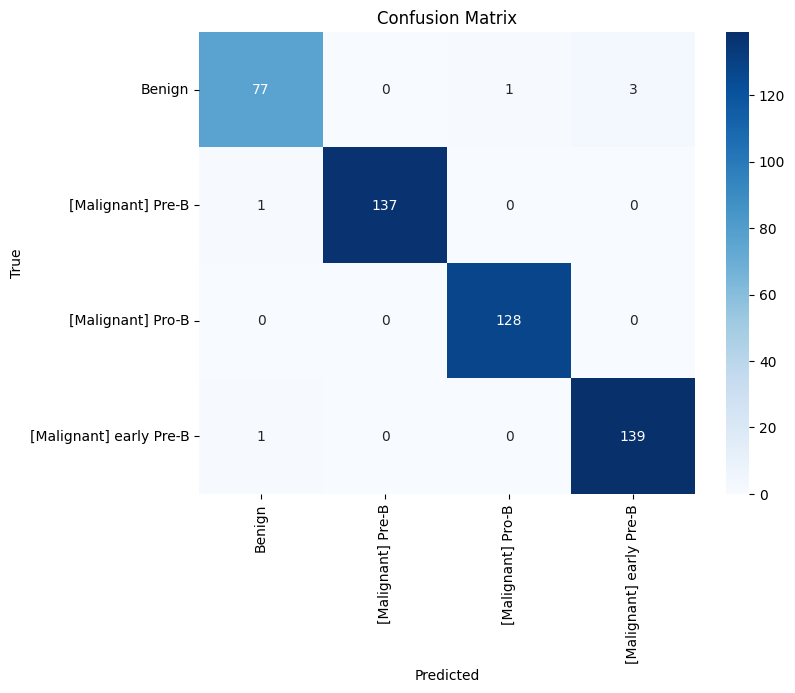

In [31]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize = (8, 6))
sns.heatmap(cm, annot = True, fmt = 'd',
            xticklabels = class_names,
            yticklabels = class_names,
            cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [33]:
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Model Evaluation Summary : \n")
print(f"Test Accuracy       : {acc*100:.2f}%")
print(f"Weighted F1 Score   : {f1:.4f}")

Model Evaluation Summary : 

Test Accuracy       : 98.77%
Weighted F1 Score   : 0.9876


# **Model Predictions**

In [35]:
def show_val_predictions(model, val_dataset, class_names, num_images=8):
    model.eval()
    plt.figure(figsize=(16, 8))

    for i in range(num_images):
        idx = random.randint(0, len(val_dataset) - 1)
        image, true_label = val_dataset[idx]
        input_img = image.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_img)
            _, pred = torch.max(output, 1)
            pred_label = pred.item()
        plt.subplot(2, num_images // 2, i + 1)
        img_np = image.permute(1, 2, 0).cpu().numpy()
        img_np = img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        img_np = img_np.clip(0, 1)

        plt.imshow(img_np)
        plt.title(f'True: {class_names[true_label]}\nPred: {class_names[pred_label]}',
                  color = 'green' if true_label == pred_label else 'red')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

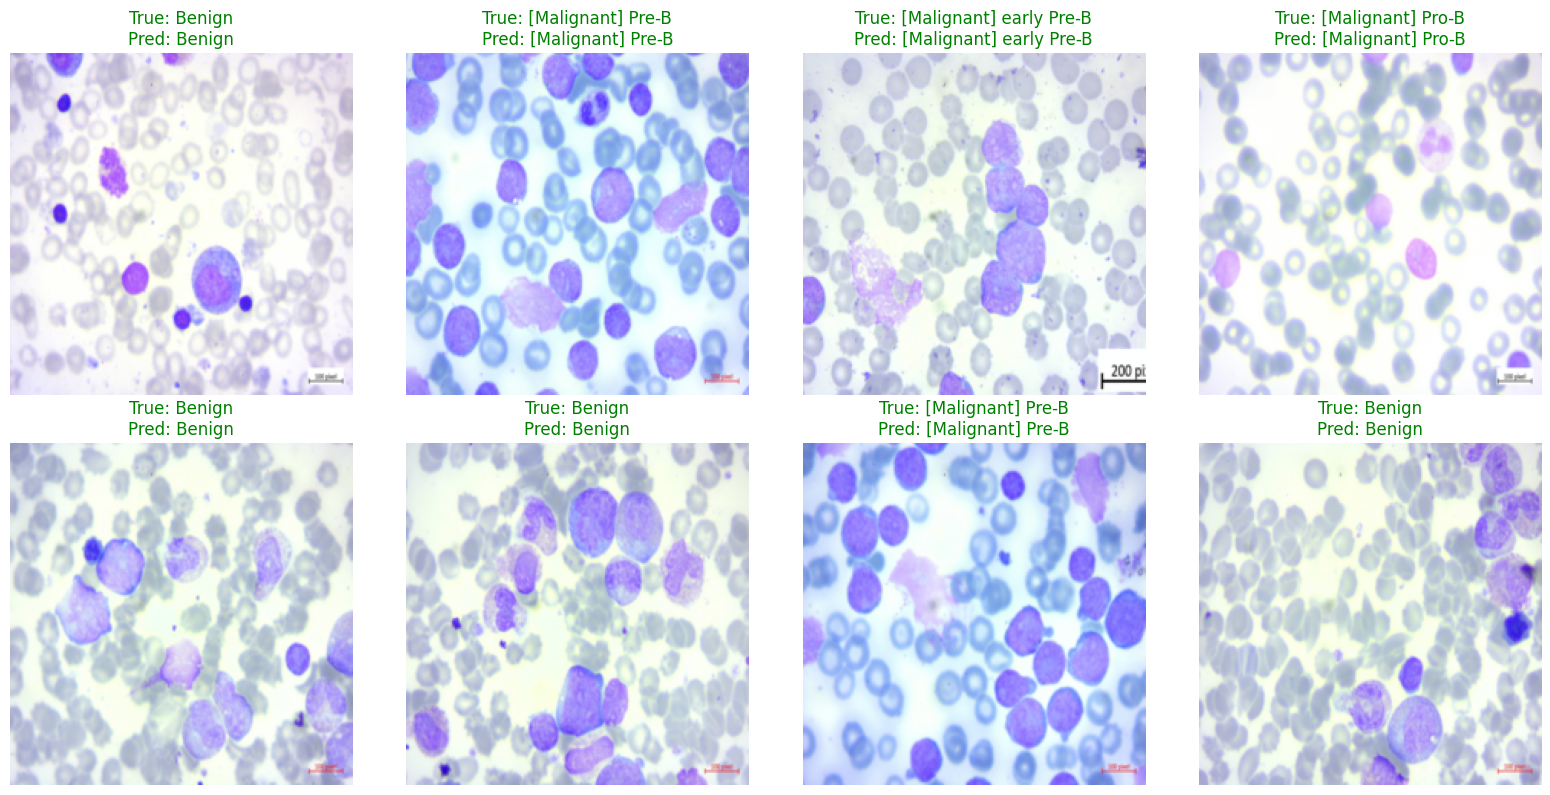

In [39]:
show_val_predictions(model, val_dataset, class_names, num_images = 8)

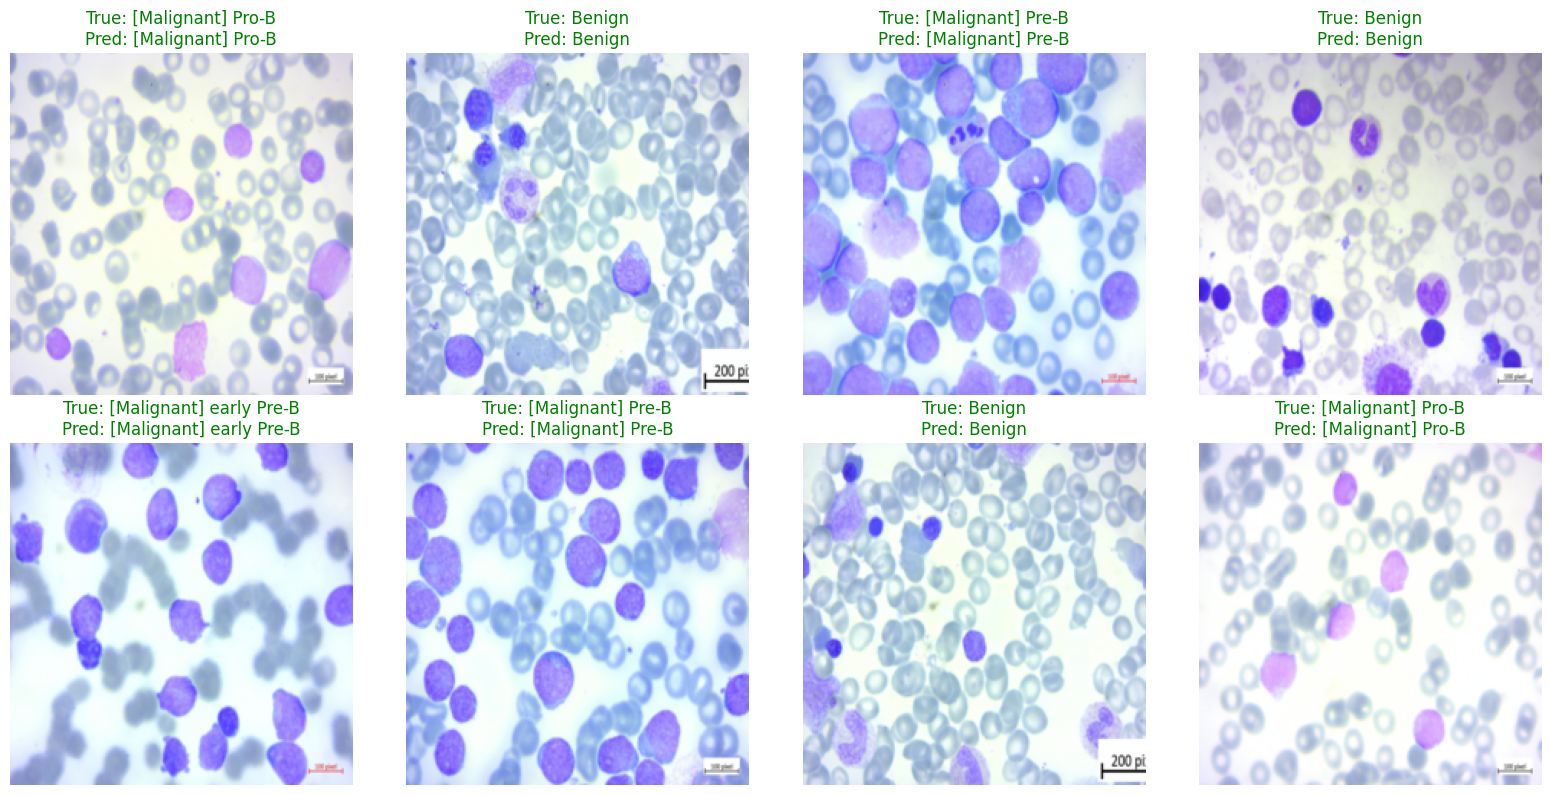

In [40]:
show_val_predictions(model, val_dataset, class_names, num_images = 8)

# **Random net imags test**

In [43]:
predict_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [48]:
def predict_on_folder(model, folder_path, class_names, max_images = 6):
    model.eval()

    image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
    image_files = image_files[:max_images] 

    plt.figure(figsize = (16, 8))

    for i, img_file in enumerate(image_files):
        img_path = os.path.join(folder_path, img_file)
        image = Image.open(img_path).convert('RGB')
        input_tensor = predict_transform(image).unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(input_tensor)
            _, pred = torch.max(outputs, 1)
            pred_label = pred.item()

        plt.subplot(2, max_images // 2, i + 1)
        plt.imshow(image)
        plt.title(f'Predicted: {class_names[pred_label]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

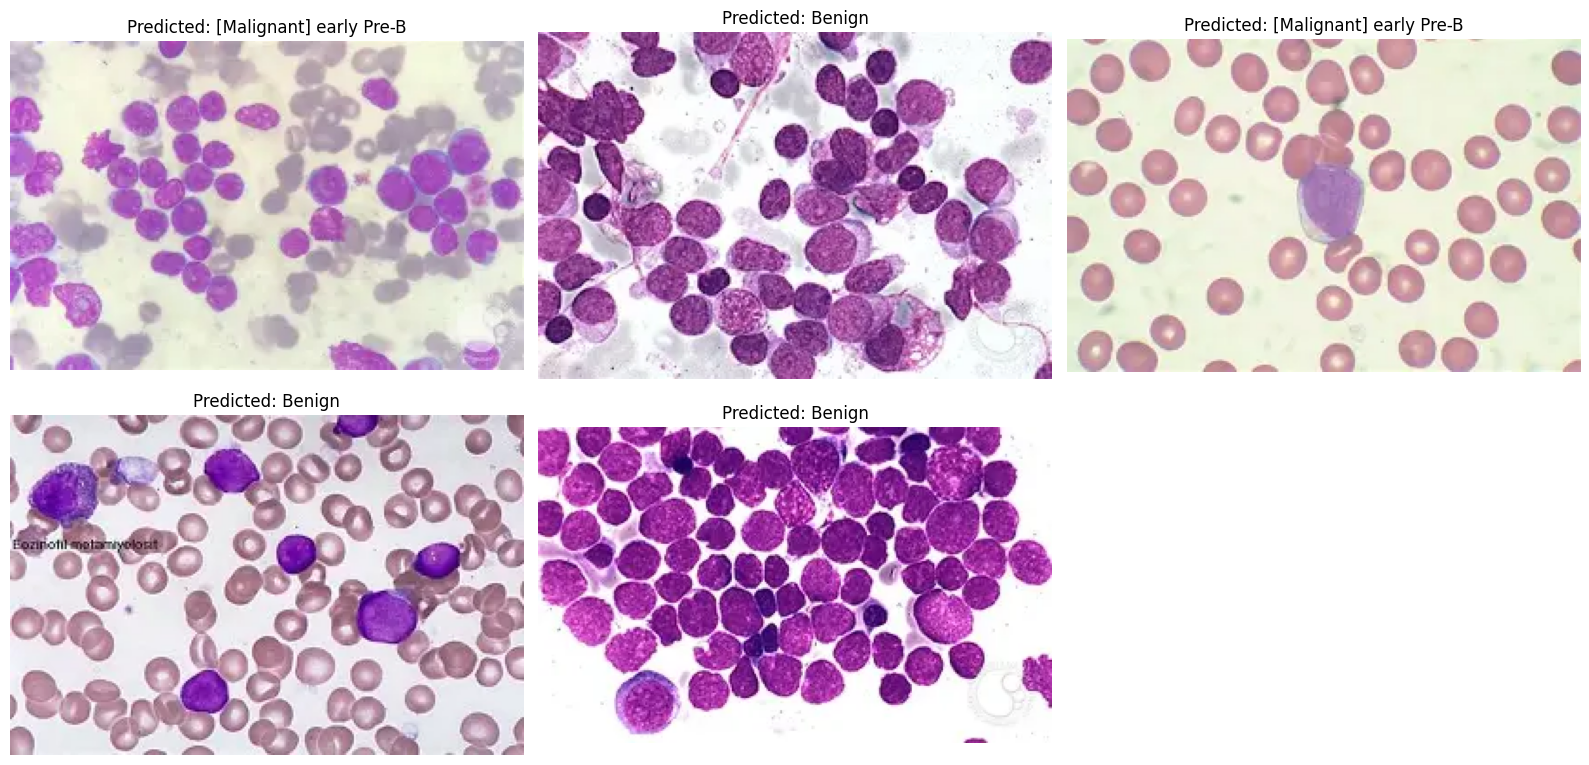

In [49]:
folder_path = '/kaggle/input/random-test-images-from-google/random test images from google'
predict_on_folder(model, folder_path, class_names, max_images = 6)

# **END**